<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/7-ensemble-learning-and-random-forests/01_voting_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Voting Classifiers

If you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of predictors
is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.

As an example of an Ensemble method, you can train a group of Decision Tree classifiers,
each on a different random subset of the training set. To make predictions, you
obtain the predictions of all the individual trees, then predict the class that gets the
most votes.

Such an ensemble of Decision Trees is
called a Random Forest, and despite its simplicity, this is one of the most powerful
Machine Learning algorithms available today.

In fact, the winning solutions in Machine Learning competitions
often involve several Ensemble methods (most famously in the Netflix Prize
competition).



##Setup

In [1]:
# Common imports
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##The law of large numbers

Suppose you have a slightly biased coin that has a 51% chance of coming up heads
and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the
math, you will find that the probability of obtaining a majority of heads after 1,000
tosses is close to 75%. The more you toss the coin, the higher the probability (e.g.,
with 10,000 tosses, the probability climbs over 97%). 

This is due to the law of large
numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).



In [2]:
heads_proba = 0.51

coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

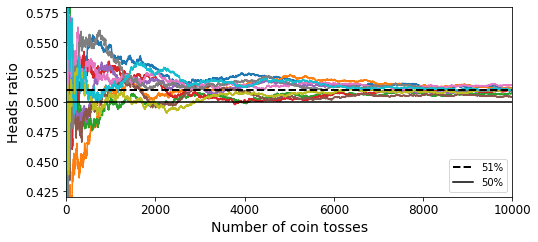

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually
all 10 series end up so close to 51% that they are consistently above 50%.

##Ensemble methods

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually
correct only 51% of the time (barely better than random guessing). If you predict
the majority voted class, you can hope for up to 75% accuracy!

However, this is
only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case because they are trained on the same data. They are likely
to make the same types of errors, so there will be many majority votes for the wrong
class, reducing the ensemble’s accuracy.

>Ensemble methods work best when the predictors are as independent
from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.

Let's creates and trains a voting classifier in Scikit-Learn, composed of
three diverse classifiers (the training set is the moons dataset).

In [4]:
X, y = make_moons(n_samples=500, noise=0.5, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], voting="hard")
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

Let’s look at each classifier’s accuracy on the test set:

In [8]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.816
RandomForestClassifier 0.712
SVC 0.792
VotingClassifier 0.8


There you have it! The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., they all have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting.

It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities.

If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy!

In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42) 
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], voting="soft")
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.816
RandomForestClassifier 0.712
SVC 0.792
VotingClassifier 0.784
